In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lib_svd import Deblurring, SuperResolution
from runner import dict2namespace, load_model_and_initialize_ddrm, load_dataset_and_task, run_evaluation

In [2]:
# Imagenet 256x256 config
config_dict = dict(
                data = dict(
                        dataset = "ImageNet",
                        image_size = 256,
                        channels = 3,
                        logit_transform = False,
                        uniform_dequantization = False,
                        gaussian_dequantization = False,
                        random_flip = True,
                        rescaled = True,
                        num_workers = 32, # was 32
                        subset_1k = True,
                        out_of_dist = False,
                        ),

                model = dict(
                        type = "openai",
                        in_channels = 3,
                        out_channels = 3,
                        num_channels = 256,
                        num_heads = 4,
                        num_res_blocks = 2,
                        attention_resolutions = "32,16,8",
                        dropout = 0.0,
                        resamp_with_conv = True,
                        learn_sigma = True,
                        use_scale_shift_norm = True,
                        use_fp16 = True,
                        resblock_updown = True,
                        num_heads_upsample = -1,
                        var_type = 'fixedsmall',
                        num_head_channels = 64,
                        image_size = 256,
                        class_cond = False,
                        use_new_attention_order = False,
                        ),

                diffusion = dict(
                        beta_schedule = 'linear',
                        beta_start = 0.0001,
                        beta_end = 0.02,
                        num_diffusion_timesteps = 1000,
                        ),

                sampling = dict(
                        batch_size = 8, # was 8
                        last_only = True,
                        )

                )

## SR4x Noiseless

In [3]:
args_dict = dict(

                exp = "./ckpts_ddrm/",
                seed = 1234,
                sigma_y = 0.0,
                task = 'sr4x',
                eta = 0.85,
                eta_b = 1.0,

                )
                
config, args, ddrm_model, schedule = load_model_and_initialize_ddrm(config_dict, args_dict)
dataset, val_loader, H = load_dataset_and_task(config, args)
run_evaluation(config, args, val_loader, ddrm_model, H)

building dataset from ./ckpts_ddrm/imagenet_val_1k.txt
read meta done
Dataset has size 1000


/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Start from 0


  0%|          | 0/125 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
PSNR = 26.59, METRIC_PSNR = 26.33, SSIM = 0.76: 100%|██████████| 125/125 [13:18<00:00,  6.39s/it]


Total Average PSNR = 26.59
Total Average Metric PSNR = 26.33
Total Average SSIM = 0.76
KID (experimental) = 7.3+-2.0
Number of samples: 1000


## SR4x Noisy (sigma = 0.05)

In [4]:
args_dict = dict(

                exp = "./ckpts_ddrm/",
                seed = 1234,
                sigma_y = 0.05,
                task = 'sr4x',
                eta = 0.85,
                eta_b = 1.0,

                )

config, args, ddrm_model, schedule = load_model_and_initialize_ddrm(config_dict, args_dict)
dataset, val_loader, H = load_dataset_and_task(config, args)
run_evaluation(config, args, val_loader, ddrm_model, H)

building dataset from ./ckpts_ddrm/imagenet_val_1k.txt
read meta done
Dataset has size 1000
Start from 0


PSNR = 25.22, METRIC_PSNR = 24.96, SSIM = 0.69: 100%|██████████| 125/125 [13:09<00:00,  6.32s/it]


Total Average PSNR = 25.22
Total Average Metric PSNR = 24.96
Total Average SSIM = 0.69
KID (experimental) = 12.71+-2.91
Number of samples: 1000


## Deblur Noiseless

In [5]:
args_dict = dict(

                exp = "./ckpts_ddrm/",
                seed = 1234,
                sigma_y = 0.0,
                task = 'deblur',
                eta = 0.85,
                eta_b = 1.0,

                )

config, args, ddrm_model, schedule = load_model_and_initialize_ddrm(config_dict, args_dict)
dataset, val_loader, H = load_dataset_and_task(config, args)
run_evaluation(config, args, val_loader, ddrm_model, H, T_ddrm_steps=20)

building dataset from ./ckpts_ddrm/imagenet_val_1k.txt
read meta done
Dataset has size 1000
Start from 0


PSNR = 38.48, METRIC_PSNR = 38.16, SSIM = 0.96:   4%|▍         | 5/125 [00:35<13:15,  6.63s/it]

PSNR = 38.71, METRIC_PSNR = 38.45, SSIM = 0.96: 100%|██████████| 125/125 [13:02<00:00,  6.26s/it]


Total Average PSNR = 38.71
Total Average Metric PSNR = 38.45
Total Average SSIM = 0.96
KID (experimental) = -0.24+-0.83
Number of samples: 1000


## Deblur Noisy (sigma = 0.05)

In [6]:
args_dict = dict(

                exp = "./ckpts_ddrm/",
                seed = 1234,
                sigma_y = 0.05,
                task = 'deblur',
                eta = 0.85,
                eta_b = 1.0,

                )

config, args, ddrm_model, schedule = load_model_and_initialize_ddrm(config_dict, args_dict)
dataset, val_loader, H = load_dataset_and_task(config, args)
run_evaluation(config, args, val_loader, ddrm_model, H)

building dataset from ./ckpts_ddrm/imagenet_val_1k.txt
read meta done
Dataset has size 1000
Start from 0


PSNR = 26.26, METRIC_PSNR = 25.97, SSIM = 0.7:   3%|▎         | 4/125 [00:27<13:07,  6.51s/it] 

PSNR = 25.45, METRIC_PSNR = 25.2, SSIM = 0.69: 100%|██████████| 125/125 [13:12<00:00,  6.34s/it] 


Total Average PSNR = 25.45
Total Average Metric PSNR = 25.2
Total Average SSIM = 0.69
KID (experimental) = 14.57+-3.62
Number of samples: 1000


NameError: name 'test_dataset' is not defined

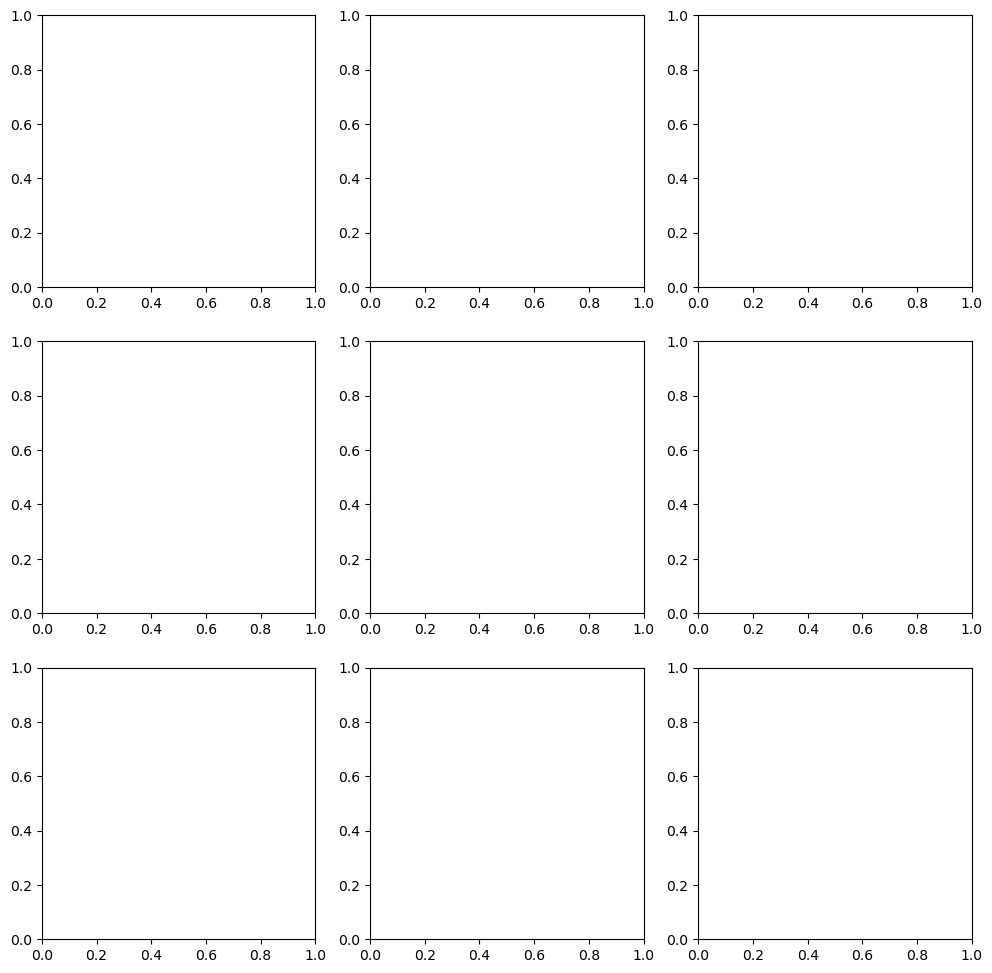

In [7]:
#visualize_degradation (numsamples, H, dataset, sigma_y=0.0, eta=1.0, eta_b=1.0, T_ddrm=20, seed=42, onlymean=False, channels=0, image_size=0):

numsamples = 3
device = torch.device("cuda")
numcols = 3
f, ax = plt.subplots(ncols=numcols, nrows=numsamples, figsize=(4*numcols,4*numsamples))
np.random.seed(seed=111)
samples = np.random.choice(np.arange(len(test_dataset)),size=None,replace=False)

samples = [samples]*numsamples

for idx,sample in enumerate(samples):
    image, label = test_dataset[sample]
    image = np.array(image, dtype=np.float32)    
    vizimage = np.transpose(image, (1, 2, 0))

    ax[idx, 0].imshow(vizimage,vmin=0.,vmax=1.)    
    ax[idx, 0].set_xticks([])
    ax[idx, 0].set_yticks([])

    #orig_shape = image.shape
    y = H.H(torch.tensor(image, device=device).reshape((1,config.data.channels,config.data.image_size,config.data.image_size)))
    y = y + (sigma_y/2) * torch.randn_like(y)
    s = int(np.sqrt(y.shape[1]//config.data.channels))
    image_degraded = y.reshape((config.data.channels, s, s)).cpu().numpy()
    image_degraded = np.transpose(image_degraded, (1, 2, 0))
    
    ax[idx, 1].imshow(image_degraded,vmin=0.,vmax=1.)    
    ax[idx, 1].set_xticks([])
    ax[idx, 1].set_yticks([])

    
    image = (image - .5) / (.5)
    y = H.H(torch.tensor(image, device=device).reshape((1,config.data.channels,config.data.image_size,config.data.image_size)))
    y = y + sigma_y * torch.randn_like(y)
    dx = torch.randn(
        y.shape[0],
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        device=device,
    )
    recovered_image = ddrm_model.reverse_diffusion_ddrm(dx, y, sigma_y, args.eta, args.eta_b, config.data.channels, config.data.image_size, H=H, T_ddrm=20, cuda=True, onlymean=False)
    recovered_image = recovered_image.cpu().numpy()
    recovered_image = np.transpose(recovered_image.reshape((config.data.channels, config.data.image_size, config.data.image_size)),(1,2,0))
    
    ax[idx, 2].imshow(.5*(recovered_image + 1.),vmin=0.,vmax=1.)    
    ax[idx, 2].set_xticks([])
    ax[idx, 2].set_yticks([])
    
    if idx == len(samples)-1:
        ax[idx, 0].set_xlabel('Original sample', fontsize=6*numcols)
        ax[idx, 1].set_xlabel('Degraded sample', fontsize=6*numcols)
        ax[idx, 2].set_xlabel('Recovered sample', fontsize=6*numcols)

